In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error # MSE probably not ideal, but good enough for now
from sklearn.linear_model import LinearRegression,BayesianRidge,Lasso
from sklearn.model_selection import KFold

In [2]:
dp = pd.read_csv('stats_and_pay_pitchers_topcols.csv')
db = pd.read_csv('stats_and_pay_batters_topcols.csv')

# load the training/test split
train_p = pd.read_csv('datasets/train_p_topcols.csv')
test_p = pd.read_csv('datasets/test_p_topcols.csv')
train_b = pd.read_csv('datasets/train_b_topcols.csv')
test_b = pd.read_csv('datasets/test_b_topcols.csv')

# merge into a single df for combined use
train = pd.merge(train_p,train_b, on=['fgid','year','pay_adj','log_pay_adj'], how='outer')
test = pd.merge(test_p,test_b, on=['fgid','year','pay_adj','log_pay_adj'], how='outer')


# remove all the ones with zero pay
train = train[train['pay_adj']>0]
test = test[test['pay_adj']>0]

In [3]:
side_cols = ['fgid','year','Season','Season_prev','pay','log_pay','adj','pay_adj','log_pay_adj']

columns_mask = np.logical_and.reduce([~np.isin(db.columns,side_cols),
                                      db.dtypes==np.float64])
batting_cols = train.columns[np.isin(train.columns,db.columns[columns_mask])]


columns_mask = np.logical_and.reduce([~np.isin(dp.columns,side_cols),
                                      dp.dtypes==np.float64])
pitching_cols = train.columns[np.isin(train.columns,dp.columns[columns_mask])]

## Simple Linear Regression Models
Model 1: Just pitching data

Model 2: Just batting data

Model 3: mixture of both

In [4]:
%%time

# make an array of zeros that will hold our mses
mses = np.zeros((3, 5))

# keep track of what split we are on
i = 0


# Make a KFold object with k=5
kfold = KFold(n_splits = 5,
              shuffle = True,
              random_state = 8675309)

for train_index, test_index in kfold.split(train.copy()):
    
    
    ### Training
    train_x = train.iloc[train_index].copy().fillna(0)
    payx = train_x['log_pay_adj'].values
    
    
    ### Holdout set
    train_y = train.iloc[test_index].copy().fillna(0)
    payy = train_y['log_pay_adj'].values
    
    
    ## Model 1
    model1 = LinearRegression(copy_X=True)
    train_x_tr1 = train_x[pitching_cols].values#poly.fit_transform(train_x[pitching_cols].values) # add polynomials
    model1.fit(train_x_tr1, payx)
    
    ## get the prediction on holdout set
    train_y_tr1 = train_y[pitching_cols].values#poly.fit_transform(train_y[pitching_cols].values)
    pred1 = model1.predict(train_y_tr1)
    
    ## record MSE
    mses[0,i] = mean_squared_error(payy, pred1)
    
    ## Model 2
    model2 = LinearRegression(copy_X=True)
    train_x_tr2 = train_x[batting_cols].values#poly.fit_transform(train_x[batting_cols].values) # add polynomials
    model2.fit(train_x_tr2, payx)
    
    ## get the prediction on holdout set
    train_y_tr2 = train_y[batting_cols].values#poly.fit_transform(train_y[batting_cols].values) # add polynomials
    pred2 = model2.predict(train_y_tr2)
    
    ## record MSE
    mses[1,i] = mean_squared_error(payy, pred2)
    
    
    ## Model 3
    model3 = LinearRegression(copy_X=True)
    train_x_tr3 = train_x[list(pitching_cols)+list(batting_cols)].values#poly.fit_transform(train_x[list(pitching_cols)+list(batting_cols)].values)
    model3.fit(train_x_tr3, payx)
    
    ## get the prediction on holdout set
    train_y_tr3 = train_y[list(pitching_cols)+list(batting_cols)].values#poly.fit_transform(train_y[list(pitching_cols)+list(batting_cols)].values)
    pred3 = model3.predict(train_y_tr3)
    
    ## record MSE
    mses[2,i] = mean_squared_error(payy, pred3)
    
    print('fold %i complete'%i)
    ## increase i by 1
    i = i + 1

fold 0 complete
fold 1 complete
fold 2 complete
fold 3 complete
fold 4 complete
CPU times: user 4.38 s, sys: 4.24 s, total: 8.62 s
Wall time: 643 ms


In [5]:
for m,MSE in enumerate(mses.mean(axis=1)):
    print('Model %i mean MSE:'%(m+1), MSE)

Model 1 mean MSE: 0.4213323112532195
Model 2 mean MSE: 0.4002174917997919
Model 3 mean MSE: 0.2515173639739915


In [6]:
# now let's use model 3 on the whole training and test set
full_train = train[list(pitching_cols)+list(batting_cols)].fillna(0).values
#full_train=poly.fit_transform(full_train) # add polynomials
model3.fit(full_train, train['log_pay_adj'].values)

full_test = test[list(pitching_cols)+list(batting_cols)].fillna(0).values
pred = model3.predict(full_test)

mean_squared_error(test['log_pay_adj'].values, pred)

0.26101668437681386

Having a small amount of loss is all well and good, but what are the actual values being predicted? How far off are they?

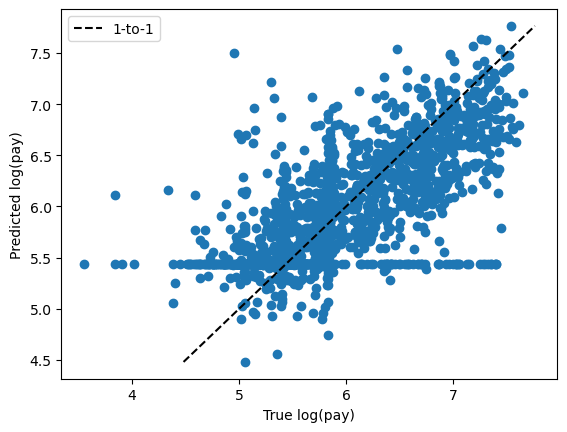

In [7]:
# while there's generally a linear correlation, it seems there is some sort of features we are missing
plt.scatter(test['log_pay_adj'].values, pred)
plt.plot([min(pred), max(pred)],[min(pred), max(pred)],'k--', label='1-to-1')
plt.xlabel('True log(pay)')
plt.ylabel('Predicted log(pay)')
plt.legend()

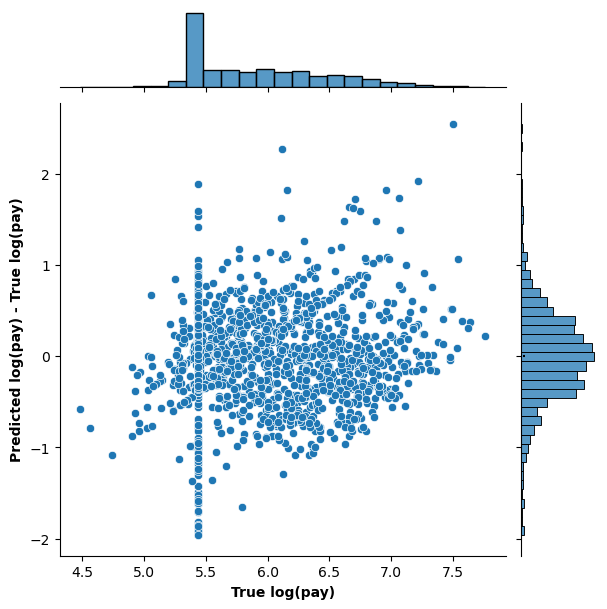

In [8]:
# plot the residuals
p = sns.jointplot(x=pred,y=pred-test['log_pay_adj'].values,kind='scatter')
p.ax_joint.set_xlabel('True log(pay)', fontweight='bold')
p.ax_joint.set_ylabel('Predicted log(pay) - True log(pay)', fontweight='bold')
plt.plot([min(pred),max(pred)], np.ones(2)*0, 'k--',label='zero residuals')

While this does technically function, we're still making predictions that are 100 times off from the true salary values. We want to at least be able to get the order of magnitude right...

---
## Try other linear models

In [9]:
# Make a KFold object with k=5
kfold = KFold(n_splits = 5,
              shuffle = True,
              random_state = 86753090)

# make an array of zeros that will hold our mses
mses = np.zeros((3, 5))

# keep track of what split we are on
i = 0

for train_index, test_index in kfold.split(train.copy()):
    ### Training
    train_x = train.iloc[train_index].copy().fillna(0)
    payx = train_x['log_pay_adj'].values
    ### Holdout set
    train_y = train.iloc[test_index].copy().fillna(0)
    payy = train_y['log_pay_adj'].values
    
    # since we're inputting the same columns in all of them, we can define the array beforehand
    
    ## Model 3
    model3 = LinearRegression(copy_X=True)
    model3.fit(train_x[list(pitching_cols)+list(batting_cols)].values, payx)
    pred3 = model3.predict(train_y[list(pitching_cols)+list(batting_cols)].values)
    mses[0,i] = mean_squared_error(payy, pred3)
    
    ## Model 4
    model4 = BayesianRidge(copy_X=True)
    model4.fit(train_x[list(pitching_cols)+list(batting_cols)].values, payx)
    pred4 = model4.predict(train_y[list(pitching_cols)+list(batting_cols)].values)
    mses[1,i] = mean_squared_error(payy, pred4)

    ## Model 5
    model5 = Lasso(copy_X=True)
    model5.fit(train_x[list(pitching_cols)+list(batting_cols)].values, payx)
    pred5 = model5.predict(train_y[list(pitching_cols)+list(batting_cols)].values)
    mses[2,i] = mean_squared_error(payy, pred5)
    ## increase i by 1
    i = i + 1

In [10]:
for m,MSE in enumerate(mses.mean(axis=1)):
    print('Model %i mean MSE:'%(m+3), MSE)

Model 3 mean MSE: 0.25836691253914823
Model 4 mean MSE: 0.2515235063409978
Model 5 mean MSE: 0.3124085666072304


In [11]:
# now let's use model 3 on the whole training and test set
full_train = train[list(pitching_cols)+list(batting_cols)].fillna(0).values
#full_train=poly.fit_transform(full_train) # add polynomials
model4.fit(full_train, train['log_pay_adj'].values)

full_test = test[list(pitching_cols)+list(batting_cols)].fillna(0).values
pred = model4.predict(full_test)

mean_squared_error(test['log_pay_adj'].values, pred)

0.2592666653749727

Having a small amount of loss is all well and good, but what are the actual values being predicted? How far off are they?

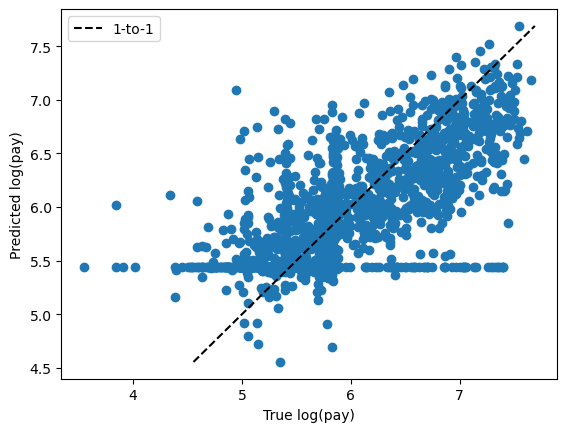

In [12]:
# while there's generally a linear correlation, it seems there is some sort of features we are missing
plt.scatter(test['log_pay_adj'].values, pred)
plt.plot([min(pred), max(pred)],[min(pred), max(pred)],'k--', label='1-to-1')
plt.xlabel('True log(pay)')
plt.ylabel('Predicted log(pay)')
plt.legend()

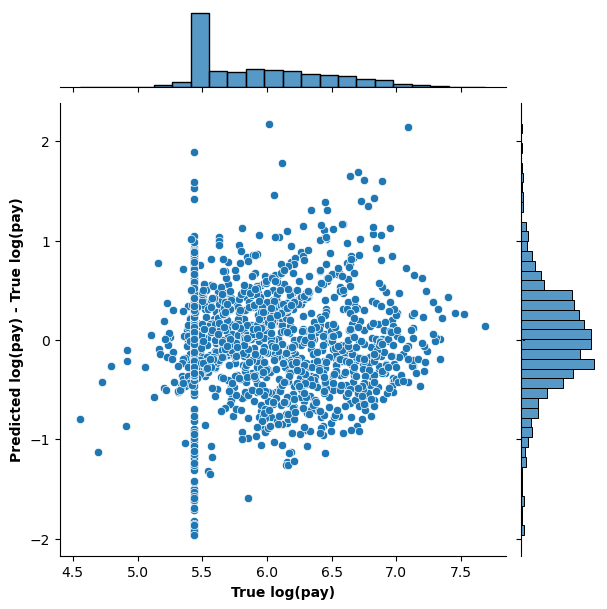

In [13]:
# plot the residuals
p = sns.jointplot(x=pred,y=pred-test['log_pay_adj'].values,kind='scatter')
p.ax_joint.set_xlabel('True log(pay)', fontweight='bold')
p.ax_joint.set_ylabel('Predicted log(pay) - True log(pay)', fontweight='bold')
plt.plot([min(pred),max(pred)], np.ones(2)*0, 'k--',label='zero residuals')


---
## Over-Under Estimation of our Model

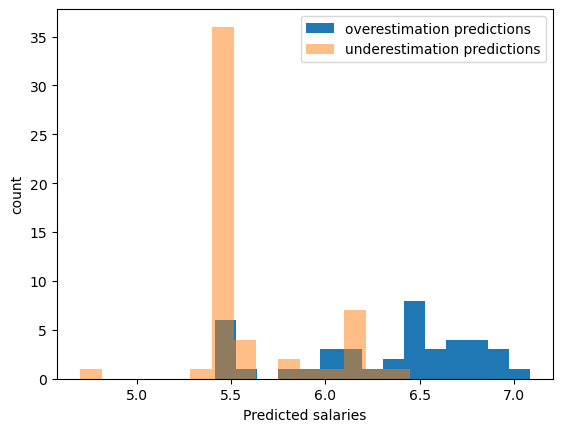

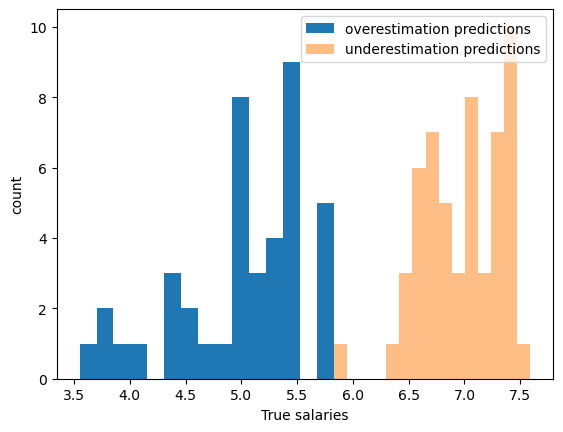

In [24]:
truths = test['log_pay_adj'].values

# let's define an acceptable range of error
error = 1.0 # we'll be generous and say we just want to get within a factor of 10

over_m = pred-truths>error
under_m = pred-truths<-error

plt.hist(pred[over_m],bins=15, label='overestimation predictions')
plt.hist(pred[under_m], bins=15,label='underestimation predictions', alpha=0.5)
plt.xlabel('Predicted salaries')
plt.ylabel('count')
plt.legend()

plt.figure()
plt.hist(truths[over_m],bins=15, label='overestimation predictions')
plt.hist(truths[under_m], bins=15,label='underestimation predictions', alpha=0.5)
plt.xlabel('True salaries')
plt.ylabel('count')
plt.legend()